## Part 1: Pulse Rate Algorithm

### Contents
Fill out this notebook as part of your final project submission.

**You will have to complete both the Code and Project Write-up sections.**
- The [Code](#Code) is where you will write a **pulse rate algorithm** and already includes the starter code.
   - Imports - These are the imports needed for Part 1 of the final project. 
     - [glob](https://docs.python.org/3/library/glob.html)
     - [numpy](https://numpy.org/)
     - [scipy](https://www.scipy.org/)
- The [Project Write-up](#Project-Write-up) to describe why you wrote the algorithm for the specific case.


### Dataset
You will be using the **Troika**[1] dataset to build your algorithm. Find the dataset under `datasets/troika/training_data`. The `README` in that folder will tell you how to interpret the data. The starter code contains a function to help load these files.

1. Zhilin Zhang, Zhouyue Pi, Benyuan Liu, ‘‘TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise,’’IEEE Trans. on Biomedical Engineering, vol. 62, no. 2, pp. 522-531, February 2015. Link

-----

### Code

In [1]:
import glob

import numpy as np

import scipy as sp
import scipy.io
import scipy.signal
import scipy.stats

import matplotlib.pyplot as plt
%matplotlib inline


def LoadTroikaDataset():
    """
    Retrieve the .mat filenames for the troika dataset.

    Review the README in ./datasets/troika/ to understand the organization of the .mat files.

    Returns:
        data_fls: Names of the .mat files that contain signal data
        ref_fls: Names of the .mat files that contain reference data
        <data_fls> and <ref_fls> are ordered correspondingly, so that ref_fls[5] is the 
            reference data for data_fls[5], etc...
    """
    data_dir = "./datasets/troika/training_data"
    data_fls = sorted(glob.glob(data_dir + "/DATA_*.mat"))
    ref_fls = sorted(glob.glob(data_dir + "/REF_*.mat"))
    return data_fls, ref_fls

def LoadTroikaDataFile(data_fl):
    """
    Loads and extracts signals from a troika data file.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

    Args:
        data_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy arrays for ppg, accx, accy, accz signals.
    """
    data = sp.io.loadmat(data_fl)['sig']
    return data[2:]

def AggregateErrorMetric(pr_errors, confidence_est):
    """
    Computes an aggregate error metric based on confidence estimates.

    Computes the MAE at 90% availability. 

    Args:
        pr_errors: a numpy array of errors between pulse rate estimates and corresponding 
            reference heart rates.
        confidence_est: a numpy array of confidence estimates for each pulse rate
            error.

    Returns:
        the MAE at 90% availability
    """
    # Higher confidence means a better estimate. The best 90% of the estimates
    #    are above the 10th percentile confidence.
    percentile90_confidence = np.percentile(confidence_est, 10)

    # Find the errors of the best pulse rate estimates
    best_estim0tes = pr_errors[confidence_est >= percentile90_confidence]

    # Return the mean absolute error
    return np.mean(np.abs(best_estimates))

def Evaluate():
    """
    Top-level function evaluation function.

    Runs the pulse rate algorithm on the Troika dataset and returns an aggregate error metric.

    Returns:
        Pulse rate error on the Troika dataset. See AggregateErrorMetric.
    """
    # Retrieve dataset files
    data_fls, ref_fls = LoadTroikaDataset()
    errs, confs = [], []
    for data_fl, ref_fl in zip(data_fls, ref_fls):
        # Run the pulse rate algorithm on each trial in the dataset
        errors, confidence = RunPulseRateAlgorithm(data_fl, ref_fl)
        errs.append(errors)
        confs.append(confidence)
        # Compute aggregate error metric
    errs = np.hstack(errs)
    confs = np.hstack(confs)
    return AggregateErrorMetric(errs, confs)

In [2]:
def bandpass_filter(signal, fs):
    """
    Runs a bandpass filter with butterworth algorithm.

    Returns:
        Bandpass filtered signal
    """          
    pass_band=(40/60.0, 240/60.0)
    b, a = scipy.signal.butter(3, pass_band, btype='bandpass', fs=fs)
    return scipy.signal.filtfilt(b, a, signal)

In [78]:
def fourier_transform(signal, fs):
    """
    Run a Fourier Transform on a signal
    
    Returns:
        Freq and Magnitude of the signal after running the FFT
    """
    freqs = np.fft.rfftfreq(2*len(signal), 1/fs)
    fft = np.abs(np.fft.rfft(signal, 2*len(signal)))
    return freqs, fft

In [83]:
def get_features(ppg, acc, fs):
    """
    Get features in our data
    
    Returns:
        PPG and ACC: Peaks, Peaks Freqency, Frequency and Magnitude after running FFT
    """
    # Fourier Transform the ppg signal
    ppg_freqs, ppg_fft = fourier_transform(ppg, fs)
    
    # Filter data
    ppg_fft[ppg_freqs <= 70/60.0] = 0.0
    ppg_fft[ppg_freqs >= 190/60.0] = 0.0
    
    # Find peaks
    ppg_peaks = sp.signal.find_peaks(ppg_fft, height=2000)[0]
    ppg_peaks_f = ppg_freqs[ppg_peaks]
    
    # Fourier Transform the acc signal
    acc_freqs, acc_fft = fourier_transform(acc, fs)
    
    # Filter data
    acc_fft[acc_freqs <= 70/60.0] = 0.0
    acc_fft[acc_freqs >= 190/60.0] = 0.0
    
    # Find peaks
    acc_peaks = sp.signal.find_peaks(acc_fft, height=None)[0]
    acc_peaks_f = acc_freqs[acc_peaks]
    
    return {'ppg': (ppg_peaks, ppg_peaks_f, ppg_freqs, ppg_fft), 'acc': (acc_peaks, acc_peaks_f, acc_freqs, acc_fft)}

In [84]:
def calculate_confidence(freqs, fft_mag, bpm_f):
    """
    Calculate the confidence of the heart rate
    
    Returns:
        Confidence of the estimated heart rate
    """
    window_f = 30/60
    fundamental_freq_window = (freqs > bpm_f - window_f) & (freqs < bpm_f + window_f)
    return np.sum(fft_mag[fundamental_freq_window])/ np.sum(fft_mag)

In [88]:
def estimate(ppg, acc, window_length_s, window_shift_s, fs):
    """
    Estimate the heart rate
    
    Returns:
        The estimated heart rate and the confidence
    """
    window_length = window_length_s * fs
    window_shift = window_shift_s * fs
    
    est_bpm = []
    confidence = []
    
    prev_est = 40/60
    
    for i in range(0, len(ppg) - window_length, window_shift):
        ppg_window = ppg[i:i+window_length]
        acc_window = acc[i:i+window_length]
        
        window_features = get_features(ppg_window, acc, fs)
        ppg_peaks, ppg_peaks_f, ppg_freqs, ppg_fft = window_features['ppg']
        acc_peaks, acc_peaks_f, acc_freqs, acc_fft = window_features['acc']
        
        ppg_max = ppg_freqs[np.argmax(ppg_fft)]
        acc_max = acc_freqs[np.argmax(acc_fft)]
        
        k = 1
        
        while np.abs(acc_max-ppg_max) <= 0.2 and k <=2:
            k+=1
            ppg_max = ppg_freqs[np.argsort(ppg_fft, axis=0)[-k]]
            acc_max = acc_freqs[np.argsort(acc_fft, axis=0)[-k]]
        
        est_bpm_f = ppg_max
        
        prev_est = est_bpm_f
        est_bpm.append(est_bpm_f*60)
        confidence.append(calculate_confidence(ppg_freqs, ppg_fft, est_bpm_f))

    return est_bpm, confidence

In [89]:
def plot_fft(signal, freqs, fft, fs):
    plt.subplot(2,1,1)
    ts = np.arange(len(signal)) / fs
    plt.plot(ts, signal)
    plt.subplot(2,1,2)
    plt.plot(freqs, np.abs(fft))
    plt.title("Frequency Domain")
    plt.xlabel("Frequency (Hz)")
    plt.tight_layout()

In [101]:
def RunPulseRateAlgorithm(data_fl, ref_fl):
    # Load data using LoadTroikaDataFile
    ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)
    bpm = sp.io.loadmat(ref_fl)['BPM0']
    
    # Our data is sampled at 125Hz
    fs = 125
    
    # Bandpass Filter
    ppg = bandpass_filter(ppg, fs)
    accx = bandpass_filter(accx, fs)
    accy = bandpass_filter(accy, fs)
    accz = bandpass_filter(accz, fs)
    
    # Calculate the magnitute of the accelerometers
    acc = np.sqrt(accx**2 + accy**2 + accz**2)
    
    # Windowing our ppg and acc signal to estimate
    window_length_s = 8
    window_shift_s = 2    
    
    # Compute pulse rate estimates and estimation confidence.
    est_bpm, confidence = estimate(ppg, acc, window_length_s, window_shift_s, fs)

    # Return per-estimate mean absolute error and confidence as a 2-tuple of numpy arrays.
    errors = np.abs(np.diag(np.subtract(bpm, est_bpm)))
    
    return errors, confidence

## TESTING SECTION

In [60]:
data_fls, ref_fls = LoadTroikaDataset()
num = 0
data_fl, ref_fl = data_fls[num], ref_fls[num]
bpm = sp.io.loadmat(ref_fl)['BPM0']
ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)
ppg = bandpass_filter(ppg, fs)
accx = bandpass_filter(accx, fs)
accy = bandpass_filter(accy, fs)
accz = bandpass_filter(accz, fs)
acc = np.sqrt(accx**2 + accy**2 + accz**2)

In [61]:
ppg_window = ppg[0:8*fs]
acc_window = acc[0:8*fs]

In [62]:
ppg_freqs, ppg_fft = fourier_transform(ppg_window, fs)

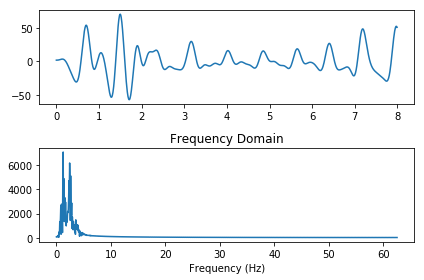

In [63]:
plot_fft(ppg_window, ppg_freqs, ppg_fft, fs)

In [64]:
acc_freqs, acc_fft = fourier_transform(acc_window, fs)

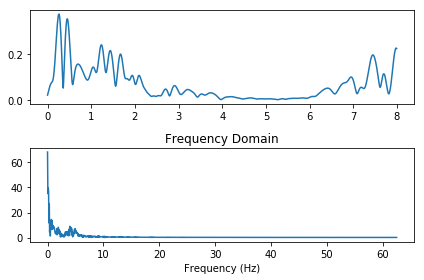

In [65]:
plot_fft(acc_window, acc_freqs, acc_fft, fs)

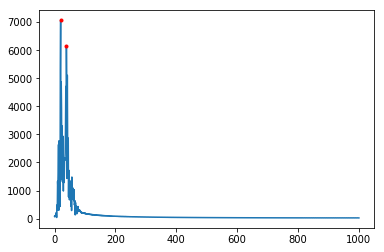

In [66]:
ppg_peaks = sp.signal.find_peaks(ppg_fft, height=2000, distance=10)[0]
plt.plot(ppg_fft)
plt.plot(ppg_peaks, ppg_fft[ppg_peaks], 'r.')

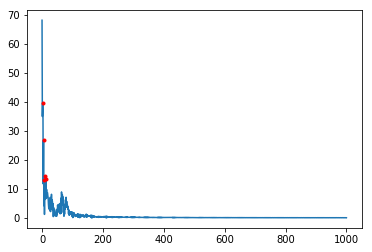

In [67]:
acc_peaks = sp.signal.find_peaks(acc_fft, height=10)[0]
plt.plot(acc_fft)
plt.plot(acc_peaks, acc_fft[acc_peaks], 'r.')

In [68]:
ppg_peaks

array([20, 39])

In [69]:
ppg_freqs[ppg_peaks]

array([ 1.25  ,  2.4375])

In [77]:
ppg_freqs[np.argmax(ppg_fft)]

1.25

In [70]:
acc_peaks

array([ 2,  5,  7, 11, 13])

In [71]:
acc_freqs[acc_peaks]

array([ 0.125 ,  0.3125,  0.4375,  0.6875,  0.8125])

In [72]:
accx_window = accx[0:8*fs]
accy_window = accy[0:8*fs]
accz_window = accz[0:8*fs]

In [73]:
accx_freqs, accx_fft = fourier_transform(accx_window, fs)
accy_freqs, accy_fft = fourier_transform(accy_window, fs)
accz_freqs, accz_fft = fourier_transform(accz_window, fs)

[ 0.6875  0.8125  1.      1.125 ]


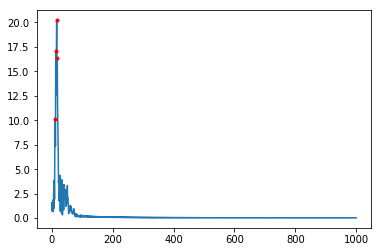

In [74]:
accx_peaks = sp.signal.find_peaks(accx_fft, height=10)[0]
plt.plot(accx_fft)
plt.plot(accx_peaks, accx_fft[accx_peaks], 'r.')
print(accx_freqs[accx_peaks])

[ 1.9375]


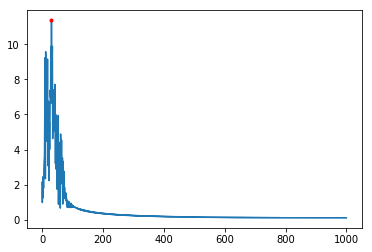

In [75]:
accy_peaks = sp.signal.find_peaks(accy_fft, height=10)[0]
plt.plot(accy_fft)
plt.plot(accy_peaks, accy_fft[accy_peaks], 'r.')
print(accy_freqs[accy_peaks])

[ 0.6875  0.8125  1.      1.25    1.375   1.5625  1.6875  1.8125  2.375
  2.5     2.625   2.75  ]


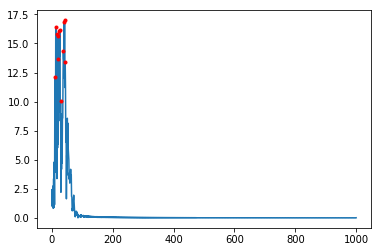

In [76]:
accz_peaks = sp.signal.find_peaks(accz_fft, height=10)[0]
plt.plot(accz_fft)
plt.plot(accz_peaks, accz_fft[accz_peaks], 'r.')
print(accz_freqs[accz_peaks])

-----
### Project Write-up

Answer the following prompts to demonstrate understanding of the algorithm you wrote for this specific context.

> - **Code Description** - Include details so someone unfamiliar with your project will know how to run your code and use your algorithm. 
> - **Data Description** - Describe the dataset that was used to train and test the algorithm. Include its short-comings and what data would be required to build a more complete dataset.
> - **Algorithhm Description** will include the following:
>   - how the algorithm works
>   - the specific aspects of the physiology that it takes advantage of
>   - a describtion of the algorithm outputs
>   - caveats on algorithm outputs 
>   - common failure modes
> - **Algorithm Performance** - Detail how performance was computed (eg. using cross-validation or train-test split) and what metrics were optimized for. Include error metrics that would be relevant to users of your algorithm. Caveat your performance numbers by acknowledging how generalizable they may or may not be on different datasets.

### CODE DESCRIPTION
- To run the result of the project, use the Evaluate() function.
- The Evaluate() function will handle the following steps:
    - Load the TROIKA data and reference files.
    - Run the PulseRate algorithm to estimate the heart rate
    - The RunPulseRate function will return estimated heart rates and their corresponding confidence

### DATA DESCRIPTION
- The data set contains:
    - PPG Signal
    - Accelerometer signal in three directions
- Those features were used to handle our heart rate estimation.
- The ECG signal is used as a reference heart rate (which can be considered as a ground truth)
- The data is quite noisy 
- We don't have much information about the subjects being collected
- The data set is collected from subject of age 18 - 35 years old. No information about the gender distribution was given.
- The subject being tested with various activities on the treadmill (rest, jog, running with different speed).

### Algorithm Desciption
#### Flow
- When running the RunPulseRate function, the following steps will occur:
    - Bandpass filter to make our signal in a reasonable range (40-240 bpm) to match with the real-life
    - Compute the aggregate accelerometer magnitude
    - Divide our signals into smaller windows of size 8s, each window is 2s apart
    - Estimate the heart rate using the window
        - Run FFT on the window signal
        - Find peaks in our frequency domain
        - Choose the correct pulse to estimate our heart rate for that window
        - Compute the confidence of the estimated heart rate
#### Specific aspect of physiology used
- The algorithm uses the accelerometor signal to filter out movement pulse from heart pulse
#### Caveats
- The algorithm requires available of acc, ppg signals and a reference bpm
#### Failure modes
- The algorithm may perform purely if there is a lot of noise in the signal

### Algorithm Performance
- The metric used to compute the error is Mean Absolute Value
- The estimated heart rate is compared with the reference measurement in the data set

-----
### Next Steps
You will now go to **Test Your Algorithm** to apply a unit test to confirm that your algorithm met the success criteria. 